# Cross Validation

In [25]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import mne
from scipy.interpolate import griddata
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
import time
from sklearn.preprocessing import StandardScaler

In [26]:
X_real_1 = np.load('../data/real_movement_class_1.npy')
X_real_2 = np.load('../data/real_movement_class_2.npy')
X_imag_1 = np.load('../data/imagined_movement_class_1.npy')
X_imag_2 = np.load('../data/imagined_movement_class_2.npy')
scaler = StandardScaler()

X_imag = np.concatenate((X_imag_1, X_imag_2), axis=0)
X_real = np.concatenate((X_real_1, X_real_2), axis=0)
y_real = np.concatenate((np.zeros(X_real_1.shape[0]), np.ones(X_real_2.shape[0])))
y_imag = np.concatenate((np.zeros(X_imag_1.shape[0]), np.ones(X_imag_2.shape[0])))
X_imag = scaler.fit_transform(X_imag)
X_real = scaler.fit_transform(X_real)

In [27]:
# alphas = [0.01, 1, 100, 10000]
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
# alphas = np.logspace(-4, 4, 20)
# alphas = np.logspace(-3, 4, num=15)  # from 1e-3 to 1e4
# alphas = alphas.tolist()
outer_folds = 6
inner_folds = 5
print("outer_folds", outer_folds)
print("inner_folds", inner_folds)
print("alphas", alphas)

outer_folds 6
inner_folds 5
alphas [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]


## Imagined Movements Cross Validation

In [28]:
outer_cv = StratifiedKFold(n_splits=6, shuffle=True)
fold_results = []

In [29]:
from joblib import Parallel, delayed

In [30]:
def evaluate_alpha(alpha, X_train_outer, y_train_outer, inner_folds, outer_fold_idx):
    inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True)
    C = 1.0 / alpha
    val_accuracies = []

    for inner_train_idx, inner_val_idx in inner_cv.split(X_train_outer, y_train_outer):
        X_train_inner = X_train_outer[inner_train_idx]
        y_train_inner = y_train_outer[inner_train_idx]
        X_val_inner = X_train_outer[inner_val_idx]
        y_val_inner = y_train_outer[inner_val_idx]

        clf = SVC(kernel='linear', C=C)
        clf.fit(X_train_inner, y_train_inner)
        val_acc = clf.score(X_val_inner, y_val_inner)
        val_accuracies.append(val_acc)

    mean_val_acc = np.mean(val_accuracies)
    return alpha, mean_val_acc

In [31]:
for outer_fold_idx, (train_idx_outer, test_idx_outer) in enumerate(
    tqdm(outer_cv.split(X_imag, y_imag), total=outer_folds, desc="🔁 Outer CV (6 folds)")
):
    X_train_outer, y_train_outer = X_imag[train_idx_outer], y_imag[train_idx_outer]
    X_test_outer, y_test_outer = X_imag[test_idx_outer], y_imag[test_idx_outer]

    # 🚀 Parallel alpha evaluation
    alpha_results = Parallel(n_jobs=-1)(
        delayed(evaluate_alpha)(alpha, X_train_outer, y_train_outer, inner_folds, outer_fold_idx)
        for alpha in tqdm(alphas, desc=f"    🔍 Alphas for Fold {outer_fold_idx+1}", leave=False)
    )

    best_alpha, best_val_acc = max(alpha_results, key=lambda x: x[1])
    best_C = 1.0 / best_alpha

    print(f"✅ Fold {outer_fold_idx+1}: Best α = {best_alpha}, Validation Accuracy = {best_val_acc:.4f}")

    clf_final = SVC(kernel='linear', C=best_C)
    clf_final.fit(X_train_outer, y_train_outer)
    y_scores = clf_final.decision_function(X_test_outer)
    y_pred = clf_final.predict(X_test_outer)

    acc = accuracy_score(y_test_outer, y_pred)
    roc = roc_auc_score(y_test_outer, y_scores)
    fpr, tpr, _ = roc_curve(y_test_outer, y_scores)

    fold_results.append({
        'fold': outer_fold_idx + 1,
        'best_alpha': best_alpha,
        'accuracy': acc,
        'roc_auc': roc,
        'fpr': fpr,
        'tpr': tpr
    })
    print(f"✅ Fold {outer_fold_idx+1}: Test Accuracy = {acc:.4f}, ROC AUC = {roc:.4f}")

🔁 Outer CV (6 folds):   0%|          | 0/6 [00:00<?, ?it/s]

    🔍 Alphas for Fold 1:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 1: Best α = 100, Validation Accuracy = 0.7765
✅ Fold 1: Test Accuracy = 0.6176, ROC AUC = 0.6263


    🔍 Alphas for Fold 2:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 2: Best α = 5, Validation Accuracy = 0.7118
✅ Fold 2: Test Accuracy = 0.8088, ROC AUC = 0.7829


    🔍 Alphas for Fold 3:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 3: Best α = 50, Validation Accuracy = 0.7588
✅ Fold 3: Test Accuracy = 0.7647, ROC AUC = 0.7638


    🔍 Alphas for Fold 4:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 4: Best α = 10, Validation Accuracy = 0.7147
✅ Fold 4: Test Accuracy = 0.7941, ROC AUC = 0.8123


    🔍 Alphas for Fold 5:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 5: Best α = 100, Validation Accuracy = 0.7559
✅ Fold 5: Test Accuracy = 0.7353, ROC AUC = 0.7474


    🔍 Alphas for Fold 6:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 6: Best α = 50, Validation Accuracy = 0.7265
✅ Fold 6: Test Accuracy = 0.7353, ROC AUC = 0.8045


In [32]:
# mean accuracy
mean_accuracy = np.mean([result['accuracy'] for result in fold_results])
print(f"Mean Accuracy: {mean_accuracy:.4f}")
# mean roc_auc
mean_roc_auc = np.mean([result['roc_auc'] for result in fold_results])
print(f"Mean ROC AUC: {mean_roc_auc:.4f}")

# Best alpha for the analysis of all fold_results
best_alpha_all = max(fold_results, key=lambda x: x['roc_auc'])['best_alpha']
print(f"Best alpha for all folds: {best_alpha_all}")

Mean Accuracy: 0.7426
Mean ROC AUC: 0.7562
Best alpha for all folds: 10


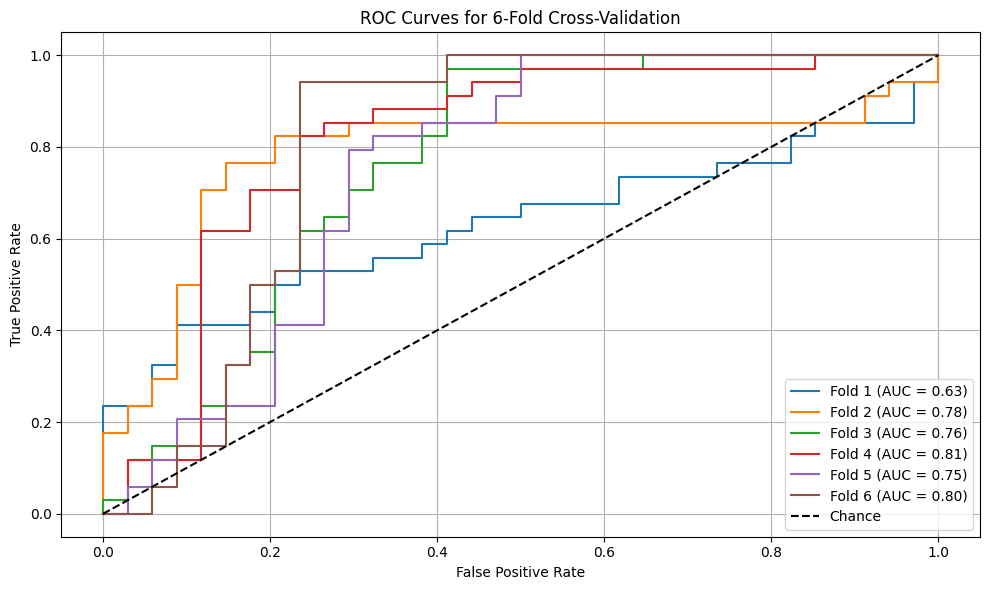

In [33]:
plt.figure(figsize=(10, 6))
for fold in fold_results:
    plt.plot(fold['fpr'], fold['tpr'], label=f"Fold {fold['fold']} (AUC = {fold['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for 6-Fold Cross-Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/roc_curves_cross_validation_imagined.png", dpi=300)
plt.show()

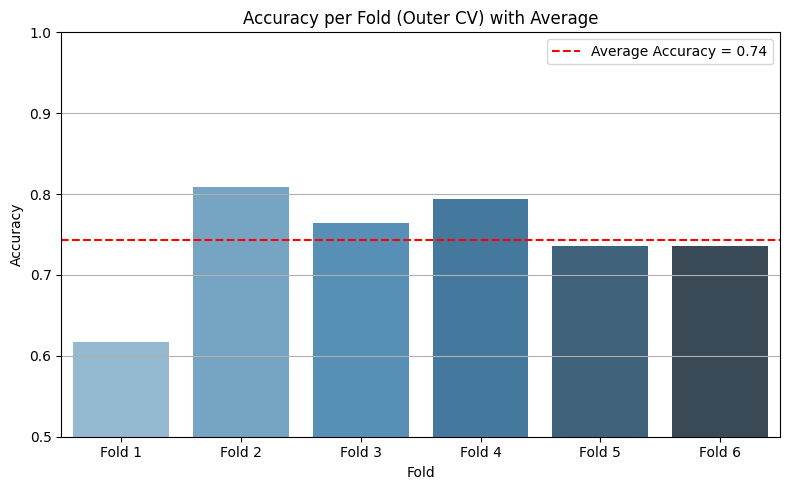

In [35]:
accuracies = [f['accuracy'] for f in fold_results]
fold_ids = [f"Fold {f['fold']}" for f in fold_results]
df_plot = pd.DataFrame({
    'Fold': [f"Fold {f['fold']}" for f in fold_results],
    'Accuracy': [f['accuracy'] for f in fold_results]
})

avg_accuracy = df_plot['Accuracy'].mean()

# Create plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='Fold', y='Accuracy', hue='Fold', palette='Blues_d', dodge=False, legend=False)
plt.axhline(avg_accuracy, color='red', linestyle='--', label=f'Average Accuracy = {avg_accuracy:.2f}')
plt.ylim(0.5, 1.0)
plt.ylabel("Accuracy")
plt.title("Accuracy per Fold (Outer CV) with Average")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("../figures/accuracy_per_fold_imagined.png", dpi=300)
plt.show()

## Real movements Cross Validation

In [36]:
fold_results = []

In [37]:
for outer_fold_idx, (train_idx_outer, test_idx_outer) in enumerate(
    tqdm(outer_cv.split(X_real, y_real), total=outer_folds, desc="🔁 Outer CV (6 folds)")
):
    X_train_outer, y_train_outer = X_real[train_idx_outer], y_real[train_idx_outer]
    X_test_outer, y_test_outer = X_real[test_idx_outer], y_real[test_idx_outer]

    # 🚀 Parallel alpha evaluation
    alpha_results = Parallel(n_jobs=-1)(
        delayed(evaluate_alpha)(alpha, X_train_outer, y_train_outer, inner_folds, outer_fold_idx)
        for alpha in tqdm(alphas, desc=f"    🔍 Alphas for Fold {outer_fold_idx+1}", leave=False)
    )

    best_alpha, best_val_acc = max(alpha_results, key=lambda x: x[1])
    best_C = 1.0 / best_alpha

    print(f"✅ Fold {outer_fold_idx+1}: Best α = {best_alpha}, Validation Accuracy = {best_val_acc:.4f}")

    clf_final = SVC(kernel='linear', C=best_C)
    clf_final.fit(X_train_outer, y_train_outer)
    y_scores = clf_final.decision_function(X_test_outer)
    y_pred = clf_final.predict(X_test_outer)

    acc = accuracy_score(y_test_outer, y_pred)
    roc = roc_auc_score(y_test_outer, y_scores)
    fpr, tpr, _ = roc_curve(y_test_outer, y_scores)

    fold_results.append({
        'fold': outer_fold_idx + 1,
        'best_alpha': best_alpha,
        'accuracy': acc,
        'roc_auc': roc,
        'fpr': fpr,
        'tpr': tpr
    })
    print(f"✅ Fold {outer_fold_idx+1}: Test Accuracy = {acc:.4f}, ROC AUC = {roc:.4f}")

🔁 Outer CV (6 folds):   0%|          | 0/6 [00:00<?, ?it/s]

    🔍 Alphas for Fold 1:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 1: Best α = 50, Validation Accuracy = 0.7588
✅ Fold 1: Test Accuracy = 0.7353, ROC AUC = 0.7327


    🔍 Alphas for Fold 2:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 2: Best α = 10, Validation Accuracy = 0.7529
✅ Fold 2: Test Accuracy = 0.7206, ROC AUC = 0.6825


    🔍 Alphas for Fold 3:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 3: Best α = 100, Validation Accuracy = 0.7265
✅ Fold 3: Test Accuracy = 0.7206, ROC AUC = 0.8080


    🔍 Alphas for Fold 4:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 4: Best α = 10, Validation Accuracy = 0.7471
✅ Fold 4: Test Accuracy = 0.6912, ROC AUC = 0.7327


    🔍 Alphas for Fold 5:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 5: Best α = 5, Validation Accuracy = 0.7735
✅ Fold 5: Test Accuracy = 0.6912, ROC AUC = 0.7085


    🔍 Alphas for Fold 6:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Fold 6: Best α = 10, Validation Accuracy = 0.7059
✅ Fold 6: Test Accuracy = 0.6765, ROC AUC = 0.7621


In [38]:
# mean accuracy
mean_accuracy = np.mean([result['accuracy'] for result in fold_results])
print(f"Mean Accuracy: {mean_accuracy:.4f}")
# mean roc_auc
mean_roc_auc = np.mean([result['roc_auc'] for result in fold_results])
print(f"Mean ROC AUC: {mean_roc_auc:.4f}")

# Best alpha for the analysis of all fold_results
best_alpha_all = max(fold_results, key=lambda x: x['roc_auc'])['best_alpha']
print(f"Best alpha for all folds: {best_alpha_all}")

Mean Accuracy: 0.7059
Mean ROC AUC: 0.7377
Best alpha for all folds: 100


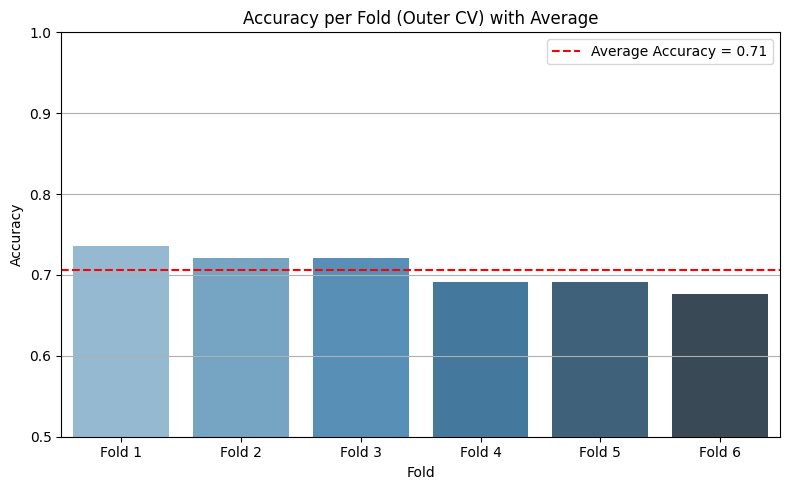

Exception ignored in: <function ResourceTracker.__del__ at 0x110a93420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1049bf420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

In [40]:
accuracies = [f['accuracy'] for f in fold_results]
fold_ids = [f"Fold {f['fold']}" for f in fold_results]
df_plot = pd.DataFrame({
    'Fold': [f"Fold {f['fold']}" for f in fold_results],
    'Accuracy': [f['accuracy'] for f in fold_results]
})

avg_accuracy = df_plot['Accuracy'].mean()

# Create plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='Fold', y='Accuracy', hue='Fold', palette='Blues_d', dodge=False, legend=False)
plt.axhline(avg_accuracy, color='red', linestyle='--', label=f'Average Accuracy = {avg_accuracy:.2f}')
plt.ylim(0.5, 1.0)
plt.ylabel("Accuracy")
plt.title("Accuracy per Fold (Outer CV) with Average")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("../figures/accuracy_per_fold_imagined.png", dpi=300)
plt.show()

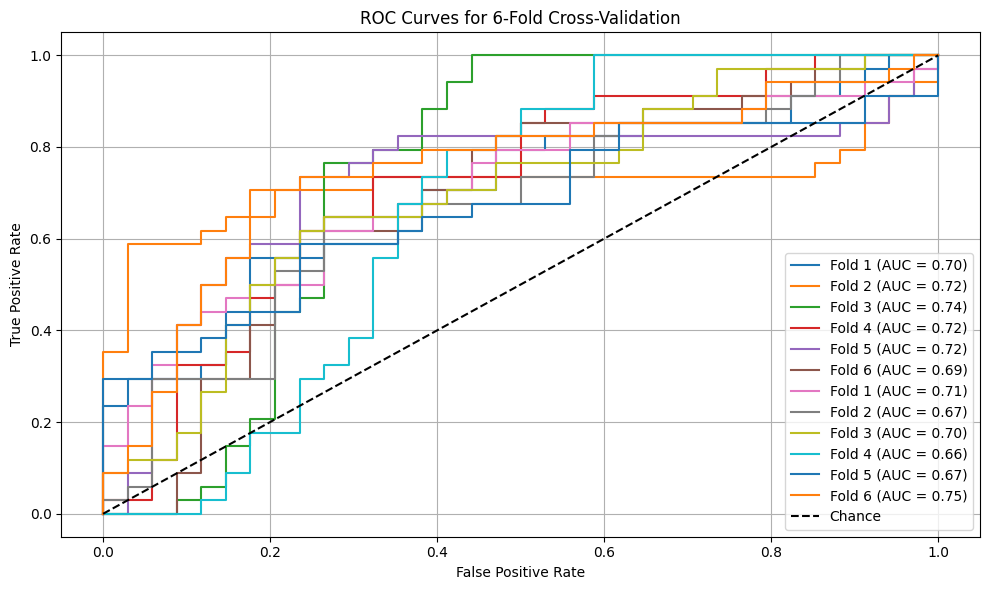

In [21]:
plt.figure(figsize=(10, 6))
for fold in fold_results:
    plt.plot(fold['fpr'], fold['tpr'], label=f"Fold {fold['fold']} (AUC = {fold['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for 6-Fold Cross-Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/roc_curves_cross_validation_real.png", dpi=300)
plt.show()